# Additional Feature

In here, we will conduct sentimental analysis on a selected subtopic. Once we decide which subtopic we want to analze, we will collect more keywords that have high relevance score through analyzing a transcprit of the video. Then, we will score the relevance between keywords and each comments and extract relevant comments. With those data set, we use it as an input to our model and generate a result of sentimental anaylsis on the subtopic.

### 1. Sentiment analysis on subtopics

**Extract** a transcript from video.

In [1]:
!pip install transformers
!pip install youtube_transcript_api

In [2]:

from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound
from youtube_transcript_api import NoTranscriptAvailable
def get_transcript(video_id):
    try:
        # Attempt to fetch the English transcript
        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
        return transcript
    except NoTranscriptAvailable:
        # Handle cases where no transcripts are available at all
        print(f"No transcripts available for video {video_id}.")
        return None
    except NoTranscriptFound:
        # Handle cases where English transcript is not found but other languages may be available
        print(f"No English transcript available for video {video_id}.")
        return None
    except TranscriptsDisabled:
        # Handle cases where transcripts are disabled for the video
        print(f"Transcripts are disabled for video {video_id}.")
        return None
    except Exception as e:
        # Handle other possible errors
        print(f"Error fetching transcript for video {video_id}: {e}")
        return None

In [3]:
def format_transcript(transcript):
    if transcript is not None:
        return ' '.join(entry['text'] for entry in transcript)
    else:
        return ""
#This could be gotten from NLP_YouTube_scrape with given keywords


In [4]:
subtopics = ['jobs']
video_ids = ['Gn6ptv0zWZ4', '_4n2mZg9pF4','kcEbA1JXyQM', '7devgjUP2pY', 'TNi9KV61ir0', 'dhg1NPqB_60', 'U9ANtZoK3H0', 'jenEIBcxImE', 'JJPWIiu-BUw', 'E7oCB8MpW8w', 'PR_ykicOZYU', 'IPmGFK065Mc']

1. Spacy : By analyzing the grammatical structure, it is possible to extract keywords by focusing on the description of subtopics in the transcript. Here, we limited the keyword extraction to nouns and extracted the top three.

In [5]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nlp = spacy.load("en_core_web_sm")
all_transcripts = []

for video_id in video_ids:
  transcripts = get_transcript(video_id)
  transcript = format_transcript(transcripts)
  if transcript:
      all_transcripts.append(transcript)

combined_transcript = ' '.join(all_transcripts)


doc = nlp(combined_transcript)
print(combined_transcript)

#for subtopic in subtopics:
#    print(f"Analyzing context for: {subtopic}")
#    related_nouns = []

    # Use dependency parsing to extract sentences related to subtopics
#    for sent in doc.sents:
#      if subtopic.lower() in sent.text.lower():  # Case-insensitive search
#            for token in sent:
#                if token.pos_ == 'NOUN':  # Extract nouns only
#                    related_nouns.append(token.text)

    # Extract keywords using TF-IDF from related phrases
#    if related_nouns:
#        vectorizer = TfidfVectorizer()
#        tfidf_matrix = vectorizer.fit_transform(related_nouns)
#        feature_array = np.array(vectorizer.get_feature_names_out())
#        tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]

#        top_keywords = feature_array[tfidf_sorting][:5]  # top 5 keyword
#        print(f"Top keywords related to {subtopic}: {top_keywords}")
#    else:
#        print(f"No significant nouns related to {subtopic} found.")

Transcripts are disabled for video E7oCB8MpW8w.
now let's turn to artificial intelligence because the international monetary fund has warned that 40% of all jobs around the world will be impacted by AI it says the effect is even more pronounced in the developed world where 60% of roles will be affected according to the IMF half of us will benefit from higher productivity but the other half uh the rise of AI could see lower salaries reduced hiring and even some jobs disappearing altogether and it increases uh inequality potentially within society and between rich and poor Nations uh let's hear from christalina goriva managing director of the IMF we must focus on helping lower income countries in particular to move faster to be able to catch the opportunities that artificial intelligence would present in other words embrace it it is coming set aside the fear of this significant change and concentrate on how you can best tap into the opportunity well the rise of AI is one of the big topic

2. Transformers (BertTokenizer, BertModel): Identifies semantic relationships between words through token embeddings that consider the text as a whole, and based on this, identifies the most contextually similar words to a specific keyword. It provides a more direct and specific similarity measure for a specific keyword.

In [6]:
from transformers import BertTokenizer, BertModel
import torch
# Initialize the model and torchizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

for video_id in video_ids:
  transcripts = get_transcript(video_id)
  transcript = format_transcript(transcripts)
  if transcript:
      all_transcripts.append(transcript)

combined_transcript = ' '.join(all_transcripts)

subtopic = ['jobs']
top_keywords = []
if combined_transcript:
    tokens = tokenizer(combined_transcript, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**tokens)
    token_embeddings = outputs.last_hidden_state.squeeze(0)

    for subtopic in subtopics:
        keyword_tokens = tokenizer.encode(subtopic, add_special_tokens=False)
        keyword_indices = [(tokens['input_ids'][0] == token_id).nonzero(as_tuple=True)[0] for token_id in keyword_tokens]
        keyword_indices = torch.cat(keyword_indices) if keyword_indices else []

        if keyword_indices.size(0) == 0:
            print(f"Subtopic '{subtopic}' not found in the combined transcripts.")
            continue

        keyword_vector = token_embeddings[keyword_indices].mean(dim=0)
        cos = torch.nn.CosineSimilarity(dim=0)
        seen_tokens = set()
        unique_similarities = []

        for idx, (token_id, token_vec) in enumerate(zip(tokens['input_ids'][0].tolist(), token_embeddings)):
            if idx not in keyword_indices.tolist() and tokenizer.decode([token_id], skip_special_tokens=True).lower() != subtopic.lower():
                word = tokenizer.decode([token_id], skip_special_tokens=True).lower()
                if word not in seen_tokens:
                    sim = cos(keyword_vector, token_vec).item()
                    seen_tokens.add(word)
                    unique_similarities.append((word, sim))

        unique_similarities.sort(key=lambda x: x[1], reverse=True)
        top_related_words = unique_similarities[:5]  # top 5 related keywords
        top_keywords = [subtopic] + [word for word, sim in top_related_words]

        print(f"Top related words for subtopic '{subtopic}': {top_related_words}")
else:
    print("No transcripts available for analysis.")
print(top_keywords)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Transcripts are disabled for video E7oCB8MpW8w.
Top related words for subtopic 'jobs': [('roles', 0.796218991279602), ('salaries', 0.7298945188522339), ('hiring', 0.6955380439758301), ('productivity', 0.6455510854721069), ('industries', 0.5423421859741211)]
['jobs', 'roles', 'salaries', 'hiring', 'productivity', 'industries']


We have tried K-cluster, word2vec but they only collect keywords based on location and frequency of words so we don't use those methods.



```
# This is formatted as code
```

##Calculate and extract comment relevance scores

In [7]:
from google.colab import drive

import pandas as pd
import numpy as np
from gensim.models import KeyedVectors

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [8]:
!pip install pandas openpyxl


In [9]:
model_file_path = '/content/drive/MyDrive/NLP/GoogleNews-vectors-negative300.bin'
xlsx_file_path = '/content/drive/MyDrive/NLP/youtube_ai_test_result_wordcloud.xlsx'

# Load CSV file and treat all data as strings
df_video_keywords = pd.read_excel(xlsx_file_path, dtype=str)
print(df_video_keywords.head())
# load word2vec model
vector_model = KeyedVectors.load_word2vec_format(model_file_path, binary=True)



  Unnamed: 0                                               text label  \
0          0  more productive br shouldn 39 we just much rat...   pos   
1          1  this is just simple the rich will get richer t...   neg   
2          2  eventually artificial intelligence will take o...   neg   
3          3  the down side of ai is that big city like berl...   pos   
4          4  quot isn 39 about making machine more human li...   pos   

  label_human (neg = Negative, pos = Positive) Unnamed: 4  \
0                                          pos       True   
1                                          neg       True   
2                                          neg       True   
3                                          neg      False   
4                                            -      False   

             updated_at   Unnamed: 6 Unnamed: 7 Unnamed: 8 with nltk  \
0  2024-01-15T16:41:10Z          NaN        NaN        NaN       pos   
1  2024-01-15T15:33:22Z     현 레이블 개수        250   

In [10]:

def compute_average_word2vec(vector_model, words, weights=None):
    word_vectors = []
    for word in words:
        if word in vector_model:
            # weight keywords
            if weights and word in weights:
                weighted_vector = vector_model[word] * weights[word]
            else:
                weighted_vector = vector_model[word]
            word_vectors.append(weighted_vector)
    if not word_vectors:
        return np.zeros(vector_model.vector_size)
    return np.mean(word_vectors, axis=0)


In [11]:
print(top_keywords)

['jobs', 'roles', 'salaries', 'hiring', 'productivity', 'industries']


In [12]:
def compute_relevance_scores(comments, top_keywords, vector_model):
    scores = []
    # weight 3 for the first keyword, 1.5 for the others
    weights = {top_keywords[0][0]: 3}
    for i in range(1, len(top_keywords)):
        weights[top_keywords[i][0]] = 1.5


    # Calculate the average vector from keywords
    keywords = [kw[0] for kw in top_keywords]
    top_terms_vec = compute_average_word2vec(vector_model, keywords, weights)

    # Calculate vectors and measure similarity of comments
    for comment in comments:
        if pd.isna(comment):  # NaN
            scores.append(0)
        else:
            comment_words = str(comment).split()  # treat comments as strings and separate them into words
            comment_vec = compute_average_word2vec(vector_model, comment_words)
            if np.linalg.norm(comment_vec) == 0 or np.linalg.norm(top_terms_vec) == 0:
                similarity_score = 0
            else:
                similarity_score = np.dot(comment_vec, top_terms_vec) / (np.linalg.norm(comment_vec) * np.linalg.norm(top_terms_vec))
                similarity_score = np.sqrt(similarity_score)  # take the square root of the score
            scores.append(similarity_score)
    return scores

# extract comment data (assuming comments are in the second column)
comments = df_video_keywords.iloc[:, 1].tolist()

# Calculate relevance score
relevance_scores = compute_relevance_scores(comments, top_keywords, vector_model)
print(df_video_keywords.iloc[:, 2].value_counts(dropna=False))

# DataFrame의 처음과 끝 일부 데이터 확인
# print results
for index, score in enumerate(relevance_scores):
    print(f"Comment Index: {index}, Relevance Score: {score:.3f}")

<ipython-input-12-4f91ed9c8015>:24: RuntimeWarning: invalid value encountered in sqrt
  similarity_score = np.sqrt(similarity_score)  # take the square root of the score


label
pos    735
neg    347
Name: count, dtype: int64
Comment Index: 0, Relevance Score: 0.623
Comment Index: 1, Relevance Score: 0.458
Comment Index: 2, Relevance Score: 0.385
Comment Index: 3, Relevance Score: 0.570
Comment Index: 4, Relevance Score: 0.580
Comment Index: 5, Relevance Score: 0.561
Comment Index: 6, Relevance Score: 0.436
Comment Index: 7, Relevance Score: 0.336
Comment Index: 8, Relevance Score: 0.507
Comment Index: 9, Relevance Score: 0.539
Comment Index: 10, Relevance Score: 0.582
Comment Index: 11, Relevance Score: 0.579
Comment Index: 12, Relevance Score: 0.245
Comment Index: 13, Relevance Score: 0.642
Comment Index: 14, Relevance Score: 0.577
Comment Index: 15, Relevance Score: 0.513
Comment Index: 16, Relevance Score: 0.474
Comment Index: 17, Relevance Score: 0.319
Comment Index: 18, Relevance Score: 0.553
Comment Index: 19, Relevance Score: 0.000
Comment Index: 20, Relevance Score: 0.470
Comment Index: 21, Relevance Score: 0.506
Comment Index: 22, Relevance Sco

Relevance Score Statistics:
count    1079.000000
mean        0.492047
std         0.139660
min         0.000000
25%         0.406546
50%         0.504677
75%         0.588808
max         0.778533
dtype: float64


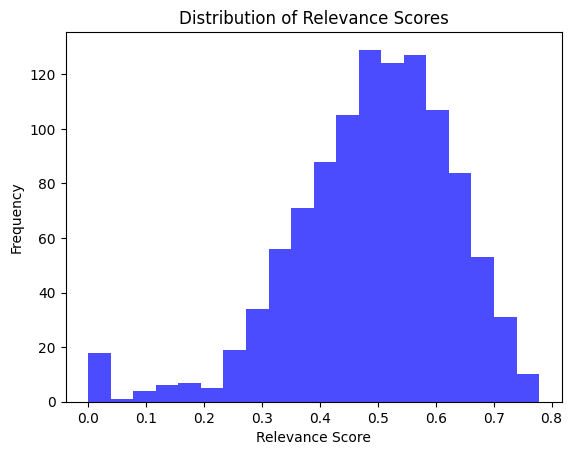

In [13]:
import matplotlib.pyplot as plt

print("Relevance Score Statistics:")
print(pd.Series(relevance_scores).describe())

plt.hist(relevance_scores, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()



After labeling each comment with relevent score, we need to decide the threshold to divide comments whether we can consider them as relevant or not.
We can do that by labeling manually 100 comments and decide the threshold or do it as median of a total score.

In [16]:

df_video_keywords['Relevance Score'] = relevance_scores

threshold = df_video_keywords['Relevance Score'].quantile(0.75)



In [17]:
filtered_df = df_video_keywords[df_video_keywords['Relevance Score'] >= threshold]

filtered_df.to_excel('/content/drive/MyDrive/NLP/filtered_youtube_comments1.xlsx', index=False)


Load ML model and label relevent comments.

In [18]:
pip install scikit-learn

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load original dataset
original_data_path = '/content/drive/MyDrive/NLP/training.1600000.processed.noemoticon.csv'
df_original = pd.read_csv(original_data_path,  encoding='latin1', header=None)
# Load filtered dataset
filtered_data_path = '/content/drive/MyDrive/NLP/filtered_youtube_comments1.xlsx'
df_filtered = pd.read_excel(filtered_data_path)

# Extract text and labels from the original data
comments_original = df_original.iloc[:, 5].fillna('')
labels_original = df_original.iloc[:, 0].map({0: 0, 4: 1}).fillna(0)

# Extract text from filtered data
comments_filtered = df_filtered.iloc[:, 1].fillna('')


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and train the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=1, ngram_range=(1, 2))
X_train = tfidf_vectorizer.fit_transform(comments_original)



In [25]:
from sklearn.naive_bayes import BernoulliNB

# Initialize and train a Bernoulli Naive Bayes model
bnb_model = BernoulliNB()
bnb_model.fit(X_train, labels_original)

BernoulliNB()

In [26]:
X_test = tfidf_vectorizer.transform(comments_filtered)


# Perform a forecast
predicted_labels = bnb_model.predict(X_test)
df_filtered['Predicted Label'] = predicted_labels

# Save the result
results_path = '/content/drive/MyDrive/NLP/labeled_filtered_comments1.xlsx'
df_filtered.to_excel(results_path, index=False)


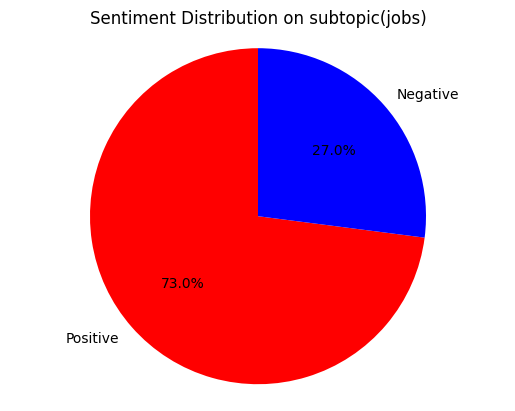

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# data load for visualization
data_path = '/content/drive/MyDrive/NLP/labeled_filtered_comments1.xlsx'
df = pd.read_excel(data_path)

labels = df.iloc[:, 14]
label_counts = labels.value_counts()

# Draw a pie chart
fig, ax = plt.subplots()
ax.pie(label_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90, colors=['red', 'Blue'])
ax.axis('equal')

plt.title('Sentiment Distribution on subtopic(jobs)')

plt.show()

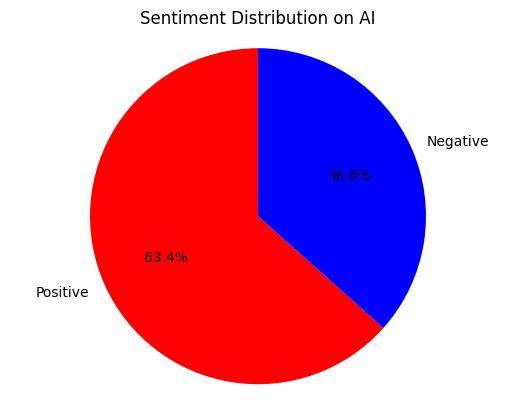

In [29]:

labels = ['Positive','Negative']
sizes = [63.4, 36.6]
colors = ['red', 'blue' ]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['red', 'blue'])
ax.axis('equal')

plt.title('Sentiment Distribution on AI')

plt.show()

###2. sentiment analysis through timeline

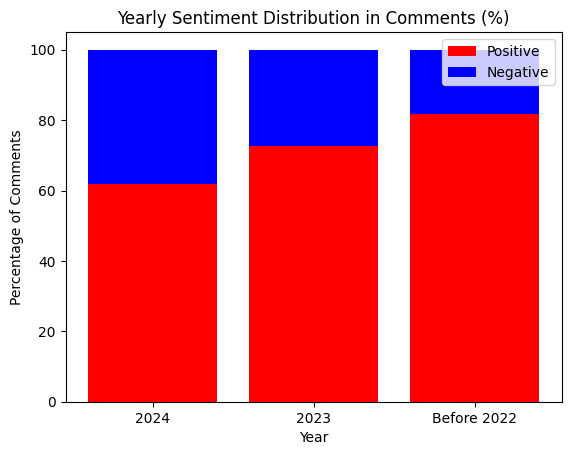

In [ ]:
import matplotlib.pyplot as plt

data = {
    '2024': {'pos': 70, 'neg': 43},
    '2023': {'pos': 37, 'neg': 14},
    'Before 2022': {'pos': 81, 'neg': 18}
}

years = list(data.keys())
positive_ratios = [data[year]['pos'] / (data[year]['pos'] + data[year]['neg']) * 100 for year in years]
negative_ratios = [data[year]['neg'] / (data[year]['pos'] + data[year]['neg']) * 100 for year in years]

fig, ax = plt.subplots()
ax.bar(years, positive_ratios, label='Positive', color='red')
ax.bar(years, negative_ratios, bottom=positive_ratios, label='Negative', color='blue')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Comments')
ax.set_title('Yearly Sentiment Distribution in Comments (%)')
ax.legend()

plt.show()




```
# This is formatted as code
```

###3. Visualization
Generate WordCloud

In [ ]:
import pandas as pd

data_path = '/content/drive/MyDrive/NLP/youtube_ai_test_result_wordcloud.xlsx'
df = pd.read_excel(data_path)

positive_comments = [str(comment) for comment in df[df.iloc[:, 2] == 'pos'].iloc[:, 1] if pd.notnull(comment)]
negative_comments = [str(comment) for comment in df[df.iloc[:, 2] == 'neg'].iloc[:, 1] if pd.notnull(comment)]


positive_text = ' '.join(positive_comments)
negative_text = ' '.join(negative_comments)




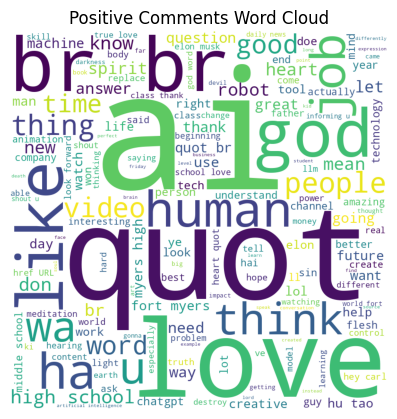

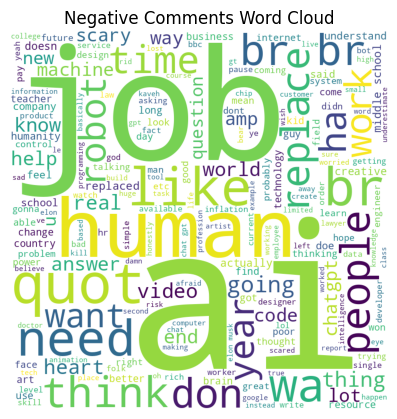

In [ ]:
import spacy

# SpaCy
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white',
                          stopwords=spacy_stopwords, min_font_size=10).generate(text)

    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

generate_wordcloud(positive_text, 'Positive Comments Word Cloud')
generate_wordcloud(negative_text, 'Negative Comments Word Cloud')